## Facial attribute detection using CNN

**Team Members**   
Sike Ogieva and Lee Mabhena  

Dataset is sourced from: https://www.kaggle.com/datasets/jessicali9530/celeba-dataset?select=list_attr_celeba.csv

In [28]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from PIL import Image
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping

**Pre-Processing Data**

In [2]:
# Read in the facial attributes dataset
dataset = pd.read_csv("archive/list_attr_celeba.csv")

In [3]:
# Print the shape of the dataset, have 202599 rows and 41 columns
dataset.shape

(202599, 41)

In [4]:
# Display the first few rows of the DataFrame to get a quick overview
print("First few rows of the dataset:")
print(dataset.head())

# Get a concise summary of the DataFrame, including the number of non-null values in each column
print("\nDataset summary:")
print(dataset.info())

# Display basic statistical details like percentile, mean, std etc. of a data frame's numeric columns
print("\nBasic statistical details:")
print(dataset.describe())

# Check for missing values in each column
print("\nMissing values in each column:")
print(dataset.isnull().sum())

# Display the names of the columns in the DataFrame
print("\nColumn names:")
print(dataset.columns)

First few rows of the dataset:
     image_id  5_o_Clock_Shadow  Arched_Eyebrows  Attractive  Bags_Under_Eyes  \
0  000001.jpg                -1                1           1               -1   
1  000002.jpg                -1               -1          -1                1   
2  000003.jpg                -1               -1          -1               -1   
3  000004.jpg                -1               -1           1               -1   
4  000005.jpg                -1                1           1               -1   

   Bald  Bangs  Big_Lips  Big_Nose  Black_Hair  ...  Sideburns  Smiling  \
0    -1     -1        -1        -1          -1  ...         -1        1   
1    -1     -1        -1         1          -1  ...         -1        1   
2    -1     -1         1        -1          -1  ...         -1       -1   
3    -1     -1        -1        -1          -1  ...         -1       -1   
4    -1     -1         1        -1          -1  ...         -1       -1   

   Straight_Hair  Wavy_Hair  We

The dataset contains 40 facial attributes. It maps imageId to the image name in the folder of images. There appear to be no null values and the dataset uses -1 to represent absense of facial attribute and 1 the presence of facial attribute. So we will change the -1 values to 0.

In [5]:
dataset.replace(-1, 0, inplace=True)

We now collect, visualize and normalise the images.

In [6]:
images_data = tf.keras.preprocessing.image_dataset_from_directory(
    "archive/img_align_celeba",
    color_mode='rgb',
    image_size=(64, 64),
    )

Found 202599 files belonging to 1 classes.


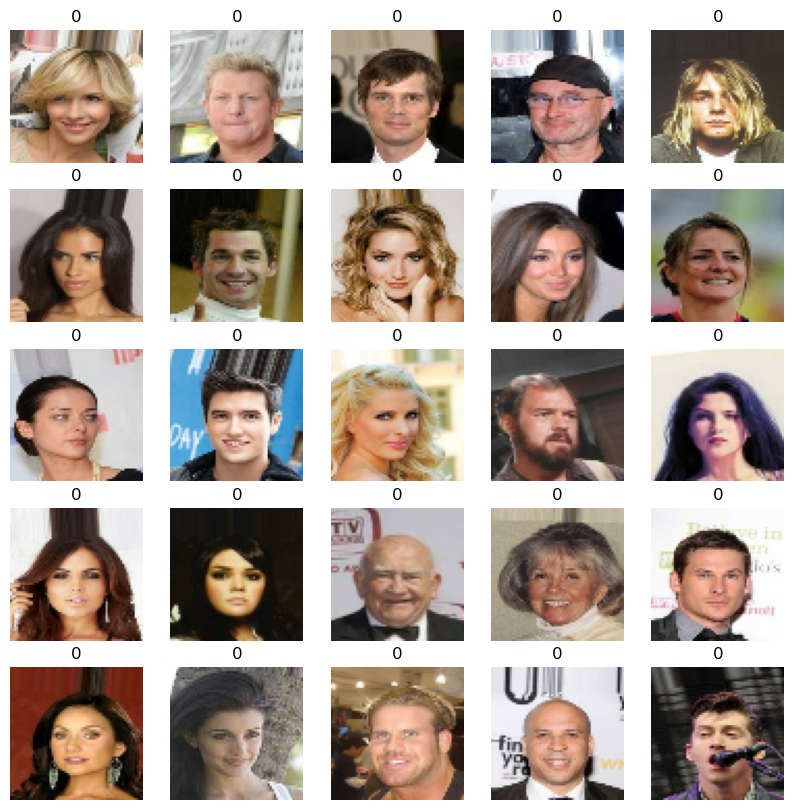

In [7]:
# Visualize the images
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10, 10))
    for n in range(25):
        ax = plt.subplot(5, 5, n + 1)
        plt.imshow(image_batch[n].numpy().astype("uint8"))
        plt.title(label_batch[n].numpy())
        plt.axis("off")

# Take a single batch of images, and their labels
image_batch, label_batch = next(iter(images_data))

# Show the images
show_batch(image_batch, label_batch)

In [8]:
# Normalize the data to be between 0 and 1
from tensorflow.keras import layers 
normalization_layer = layers.Rescaling(1./255)

normalized_data = images_data.map(lambda x, y: (normalization_layer(x), y))

**Splitting the Data**

The authors of the dataset recommend splitting the dataset in the following way: Images 1-162770 are training, 162771-182637 are validation, 182638-202599 are testing. This is the format we will use in splitting the dataset. The split is 80%, 10%, 10%.

In [33]:
# Collect and normalize X
paths = []
path_header = 'archive/img_align_celeba/img_align_celeba/'
image_ids_list = dataset['image_id'].tolist()

for image_id in image_ids_list:
    path = path_header + str(image_id)
    paths.append(path)
    
images = np.array([np.array(Image.open(path).resize((64,64))) for path in paths])
images = images.astype('float32') / 255.0  # normalize images to be in the range [0, 1]

In [41]:
# Collect Y
labels = dataset.drop('image_id', axis=1)

In [42]:
# Define the indices for splits
train_end, test_start, test_end, valid_start  = 162770, 162771, 182637, 182638

In [43]:
# Split the images into training, testing and validation
train_data_X = images[:train_end]
test_data_X = images[test_start:test_end]
valid_data_X = images[valid_start:]

# Verify the split
train_data_X.shape, test_data_X.shape, valid_data_X.shape

((162770, 64, 64, 3), (19866, 64, 64, 3), (19961, 64, 64, 3))

In [44]:
# Split the labels into training, testing and validation
train_data_Y = labels[:train_end]
test_data_Y = labels[test_start:test_end]
valid_data_Y = labels[valid_start:]

# Verify the split
train_data_Y.shape, test_data_Y.shape, valid_data_Y.shape

((162770, 40), (19866, 40), (19961, 40))

Now, this is a massive dataset so we train, validate and test on only 20% of it. Because when I tried to do it all, my computer was literally about to catch fire. So. But this step is optional so feel free to comment it out, in later revisions. Or if you have a better computer (and more patience).

**Model Definition**

In [62]:
# model definition
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(64, 64, 3)))
model.add(MaxPool2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform'))
model.add(MaxPool2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform'))
model.add(MaxPool2D((2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(40, activation='sigmoid')) # output layer

# loss function and optimizer
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [63]:
es = EarlyStopping(patience = 5, min_delta = 0.01, restore_best_weights = True)

In [ ]:
# training
network_history = model.fit(
    train_data_X, train_data_Y, 
    validation_data = (valid_data_X, valid_data_Y), 
    batch_size = 128, epochs = 10000000000,
    verbose = 1, callbacks = [es]
)

Epoch 1/10000000000
1272/1272 [==============================] - 119s 93ms/step - loss: 0.5576 - accuracy: 0.0145 - val_loss: 0.3320 - val_accuracy: 0.0146
Epoch 2/10000000000
1272/1272 [==============================] - 126s 99ms/step - loss: 0.3152 - accuracy: 0.0142 - val_loss: 0.3106 - val_accuracy: 0.0136
Epoch 3/10000000000
1272/1272 [==============================] - 127s 100ms/step - loss: 0.3012 - accuracy: 0.0146 - val_loss: 0.3003 - val_accuracy: 0.0164
Epoch 4/10000000000
1272/1272 [==============================] - 126s 99ms/step - loss: 0.2921 - accuracy: 0.0149 - val_loss: 0.2949 - val_accuracy: 0.0158
Epoch 5/10000000000
1272/1272 [==============================] - 126s 99ms/step - loss: 0.2858 - accuracy: 0.0156 - val_loss: 0.2875 - val_accuracy: 0.0159
Epoch 6/10000000000
1272/1272 [==============================] - 132s 104ms/step - loss: 0.2794 - accuracy: 0.0156 - val_loss: 0.2804 - val_accuracy: 0.0148
Epoch 7/10000000000
1272/1272 [==============================]

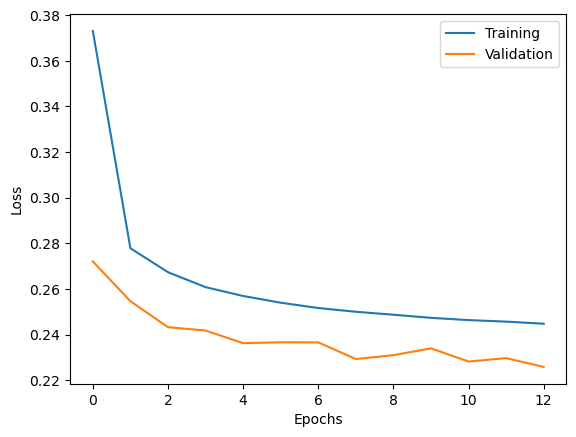

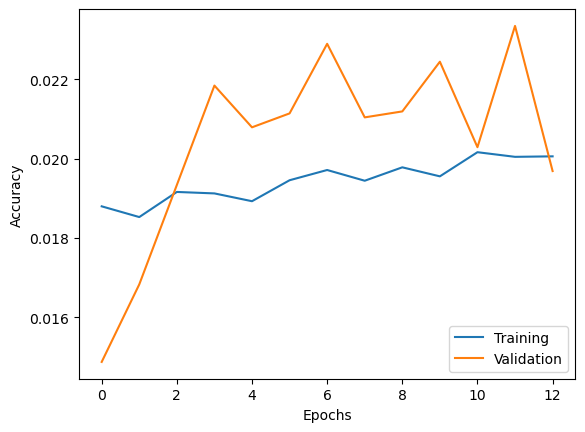

In [61]:
def plot_history(network_history):
    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.plot(network_history.history['loss'])
    plt.plot(network_history.history['val_loss'])
    plt.legend(['Training', 'Validation'])

    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.plot(network_history.history['accuracy'])
    plt.plot(network_history.history['val_accuracy'])
    plt.legend(['Training', 'Validation'], loc='lower right')
    plt.show()

plot_history(network_history)

**Model Evaluation**

In [49]:
predictions = model.predict(test_data_X)

621/621 [==============================] - 9s 14ms/step


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Calculate metrics using the actual and predicted labels
accuracy = accuracy_score(test_data_Y, predictiona)
# precision = precision_score(Y_test_dense, preds, average='macro')
# recall = recall_score(Y_test_dense, preds, average='macro')
# f1 = f1_score(Y_test_dense, preds, average='macro')

accuracy

In [60]:
predictions[0]

array([3.81781548e-01, 9.68360007e-02, 5.24100363e-01, 3.42180789e-01,
       5.52337260e-05, 1.30753673e-03, 1.74472824e-01, 6.66176260e-01,
       8.27394187e-01, 7.37104529e-06, 9.76311881e-03, 2.63594221e-02,
       9.70140040e-01, 1.83261424e-01, 6.24083616e-02, 3.37372208e-03,
       9.22841430e-01, 1.01880956e-04, 1.64782061e-04, 6.61080107e-02,
       9.99997675e-01, 6.65279254e-02, 7.77662396e-01, 1.36712000e-01,
       3.38912127e-03, 3.11295480e-01, 4.82782442e-03, 2.63183504e-01,
       4.34822217e-03, 6.29951851e-03, 9.49290395e-01, 2.51275927e-01,
       3.20967622e-02, 8.49286914e-01, 5.97507053e-04, 2.67371675e-03,
       6.06674294e-05, 3.09394416e-03, 4.76323724e-01, 6.50122225e-01],
      dtype=float32)

In [59]:
test_data_Y.head()

,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,Blond_Hair,...,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
162771,0,0,0,0,0,0,0,1,1,0,...,1,1,0,1,0,0,0,0,1,0
162772,0,1,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,1
162773,1,0,1,0,0,0,0,0,0,0,...,0,1,1,0,0,0,0,0,1,1
162774,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,1
162775,0,0,1,0,0,1,0,0,1,0,...,0,1,0,0,1,0,1,0,0,1


Please upload the following materials to the GitHub repository of your project work and submit the URL again:

Python code that downloads, prepares and loads the data (this was the task of Milestone 1, now you have only to adjust it to the other parts of your code)
Python code that trains a deep learning model,
Python code that evaluates the results on a (separate) test set,
Updated README.MD file with instructions how to run the code.
Please add as much comments to your code as much is needed to be able to easily understand it. 